In [1]:
import h5py


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input, Concatenate, UpSampling2D,Conv2DTranspose


In [3]:
img_height, img_width = 128,128

def normalize(input_image):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  return input_image


def decode_img(img):

  img = tf.image.decode_bmp(img)
  img = img[..., :3]
  return tf.image.resize(img, [img_height, img_width])

def decode_mask_img(img):

  img = tf.image.decode_jpeg(img, channels=1)
  img = img[..., :3]
  img = tf.image.grayscale_to_rgb(img)
  return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
    img = normalize(decode_img(tf.io.read_file(file_path)))
    img = tf.image.resize(img, [128, 128])
    
    file_id = tf.strings.split(file_path, '/')[-1]  # Get the file name from the path
    file_id = tf.strings.regex_replace(file_id, '\\.bmp$', '')  # Remove .bmp extension

    # Dynamically construct paths using tf.strings.join
    table_mask_path = tf.strings.join(['Mdata/table_mask/', file_id, '.jpeg'])
    column_mask_path = tf.strings.join(['Mdata/column_mask/', file_id, '.jpeg'])

    table_mask = normalize(decode_mask_img(tf.io.read_file(table_mask_path)))
    column_mask = normalize(decode_mask_img(tf.io.read_file(column_mask_path)))

    return img, {"table_output": table_mask, "column_output": column_mask}


In [4]:
import os
directory = 'Marmot_data'
files_and_dirs = os.listdir(directory)
num_files = len(files_and_dirs)

print(f"Number of files and directories in the folder: {num_files}")

Number of files and directories in the folder: 990


In [5]:

bmp_files = tf.io.gfile.glob('Marmot_data/*.bmp')


# Filter out file paths that no longer exist and normalize them
valid_files = [os.path.normpath(f).replace('\\', '/') for f in bmp_files if tf.io.gfile.exists(f)]
#print(valid_files)


bmp_files_tensor = tf.convert_to_tensor(valid_files, dtype=tf.string)

# Create the updated tf.data.Dataset with normalized files only
list_ds = tf.data.Dataset.from_tensor_slices(bmp_files_tensor)
#print(type(list_ds))
print(len(list_ds))

494


In [14]:

DATASET_SIZE = len(list(list_ds))
train_size = int(0.9 * DATASET_SIZE)
test_size = int(0.1 * DATASET_SIZE)

train = list_ds.take(train_size)
test = list_ds.skip(train_size)
TRAIN_LENGTH = len(list(train))
BATCH_SIZE = 2
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train = train.shuffle(BUFFER_SIZE)

train = train.map(process_path,
                      num_parallel_calls=tf.data.experimental.AUTOTUNE)

test = test.map(process_path)
train_dataset = train.shuffle(50).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

test_dataset = test.shuffle(50).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
print(TRAIN_LENGTH)
print(len(test_dataset))

444
25


In [16]:
from tensorflow.keras.models import load_model

# Load the saved model from the .keras file
model = load_model('stored_model/3/model_googlenet_new2.keras')

# Display the model architecture
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_191 (Conv2D)            (None, 63, 63, 32)   864         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_188 (Batch  (None, 63, 63, 32)  96          ['conv2d_191[0][0]']             
 Normalization)                                                                                   
                                                                                            

(128, 128, 3)


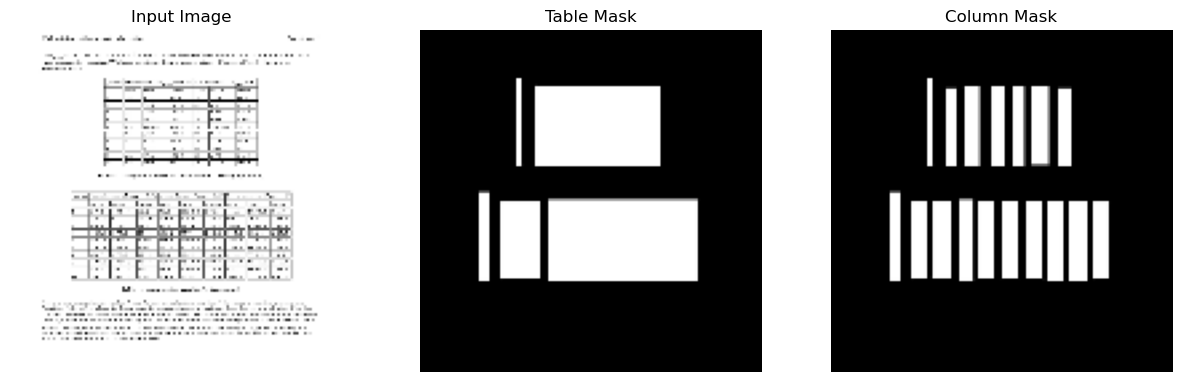

In [17]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'Table Mask', 'Column Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()


for image,mask in train.take(1):

  print(image.shape)
  #print(mask.shape)
  display([image, mask['table_output'], mask['column_output']])

In [55]:
for image, mask in train.take(1):
    predictions = model.predict(image[tf.newaxis, ...])
    print(1)
    # Apply mask creation
   


1/1 [==============================] - 0s 16ms/step
1


In [73]:

def create_mask_column(pred_mask, threshold=0.4):
    # Apply threshold for column prediction (pixel-wise thresholding)
    segmented_mask = tf.cast(pred_mask > threshold, tf.int32)  # 1 if > threshold, else 0
      # Add channel dimension for consistency
    return segmented_mask

def create_mask_table(pred_mask, threshold=0.5):
    # Apply threshold for table prediction (pixel-wise thresholding)
    segmented_mask = tf.cast(pred_mask > threshold, tf.int32)  # 1 if > threshold, else 0
    return segmented_mask

2
3
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)


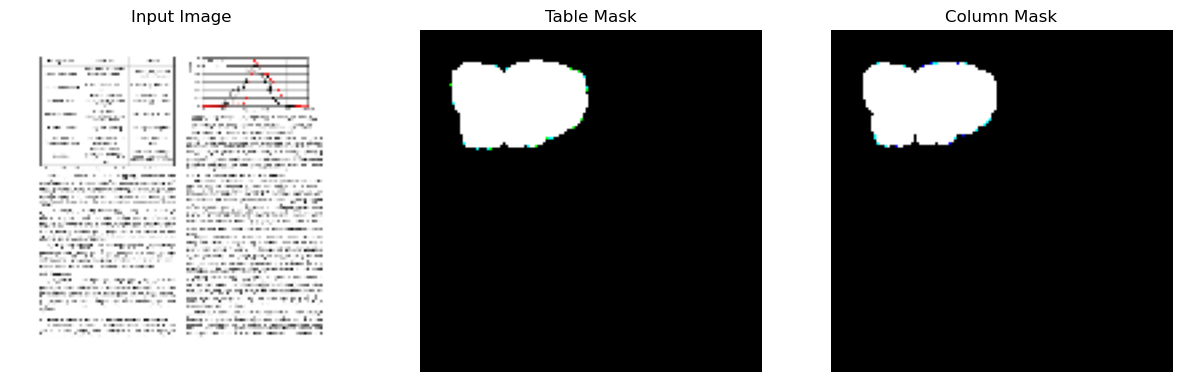

4


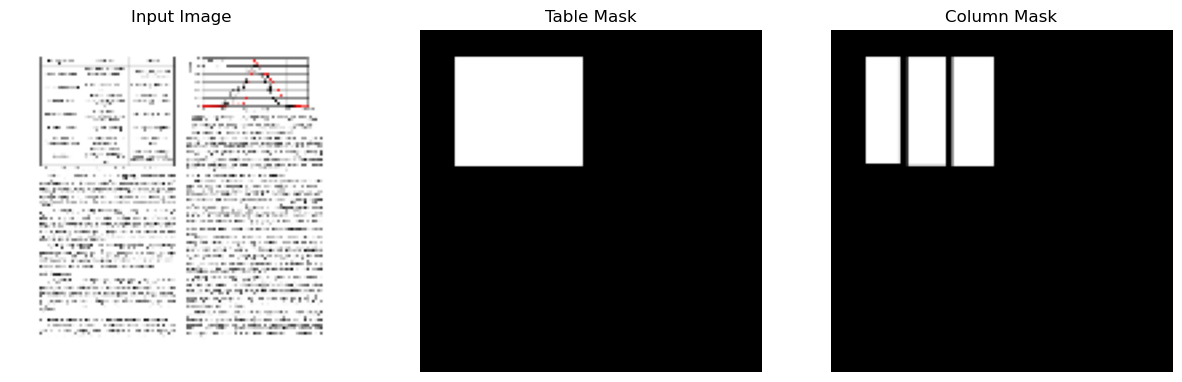

In [89]:
table_mask = tf.squeeze(create_mask_table(predictions[0]),axis=0)
print(2)
column_mask = tf.squeeze(create_mask_column(predictions[1]), axis=0)
print(3)
print(image.shape)
print(table_mask.shape)
print(column_mask.shape)
# Visualize the results
display([image, table_mask, column_mask])
print(4)
display([image, mask['table_output'], mask['column_output']])

In [75]:
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

# Lists to store predictions and true labels for both table and column masks
y_true_table, y_pred_table = [], []
y_true_column, y_pred_column = [], []

# Define a threshold to binarize predictions
threshold_value = 0.4

# Step 1: Iterate over batches in the test dataset
for image_batch, label_batch in test_dataset:
    # Step 2: Predict the masks for the current batch
    predictions = model.predict(image_batch)
    
    # Step 3: Extract predicted masks
    predicted_table_mask = predictions[0]
    predicted_column_mask = predictions[1]
    
    # Convert predictions to binary masks (for pixel-wise classification)
    binary_table_pred = np.where(predicted_table_mask > threshold_value, 1, 0).astype(np.uint8)
    binary_column_pred = np.where(predicted_column_mask > threshold_value, 1, 0).astype(np.uint8)
    
    # Step 4: Append predictions and true labels for table mask
    y_pred_table.extend(binary_table_pred.flatten())
    y_true_table.extend(label_batch["table_output"].numpy().astype(np.uint8).flatten())
    
    # Step 5: Append predictions and true labels for column mask
    y_pred_column.extend(binary_column_pred.flatten())
    y_true_column.extend(label_batch["column_output"].numpy().astype(np.uint8).flatten())

# Step 6: Calculate F1 score, precision, recall, and accuracy for table_output
f1_table = f1_score(y_true_table, y_pred_table, average='weighted')
precision_table = precision_score(y_true_table, y_pred_table, average='weighted')
recall_table = recall_score(y_true_table, y_pred_table, average='weighted')
accuracy_table = accuracy_score(y_true_table, y_pred_table)

# Step 7: Calculate F1 score, precision, recall, and accuracy for column_output
f1_column = f1_score(y_true_column, y_pred_column, average='weighted')
precision_column = precision_score(y_true_column, y_pred_column, average='weighted')
recall_column = recall_score(y_true_column, y_pred_column, average='weighted')
accuracy_column = accuracy_score(y_true_column, y_pred_column)

# Output the metrics
print(f"Table Output - F1 Score: {f1_table}, Precision: {precision_table}, Recall: {recall_table}, Accuracy: {accuracy_table}")
print(f"Column Output - F1 Score: {f1_column}, Precision: {precision_column}, Recall: {recall_column}, Accuracy: {accuracy_column}")


1/1 [==============================] - 0s 38ms/step
Table Output - F1 Score: 0.8990682185274715, Precision: 0.8975048598732758, Recall: 0.9016878255208334, Accuracy: 0.9016878255208334
Column Output - F1 Score: 0.8933828588263137, Precision: 0.8945153919161755, Recall: 0.8923356119791667, Accuracy: 0.8923356119791667
